In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [ ]:
# Install library Sastrawi
!pip -q install sastrawi

     |████████████████████████████████| 209 kB 4.9 MB/s 


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 01 Data Acquisition


In [ ]:
# Download dataset
!wget https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_komentar_instagram_cyberbullying.csv

--2022-10-06 03:00:03--  https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_komentar_instagram_cyberbullying.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65494 (64K) [text/plain]
Saving to: ‘dataset_komentar_instagram_cyberbullying.csv’

dataset_komentar_in 100%[===================>]  63.96K  --.-KB/s    in 0.01s   

2022-10-06 03:00:03 (6.50 MB/s) - ‘dataset_komentar_instagram_cyberbullying.csv’ saved [65494/65494]



In [ ]:
data = pd.read_csv('dataset_komentar_instagram_cyberbullying.csv')
data.head()

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      400 non-null    int64 
 1   Sentiment               400 non-null    object
 2   Instagram Comment Text  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


In [ ]:
print('Total Jumlah Comment:', data.shape[0], 'data\n')
print('terdiri dari (sentiment):')
print('-- [0] negatif\t:', data[data.Sentiment == 'negative'].shape[0], 'data')
print('-- [1] positif\t:', data[data.Sentiment == 'positive'].shape[0], 'data')

Total Jumlah Comment: 400 data

terdiri dari (sentiment):
-- [0] negatif	: 200 data
-- [1] positif	: 200 data


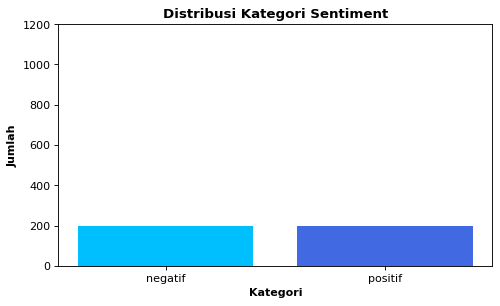

In [ ]:
height = data['Sentiment'].value_counts()
labels = ('negatif', 'positif')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,1200)
plt.title('Distribusi Kategori Sentiment', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# 02 Text Preprocessing

## Case Folding

In [ ]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [ ]:
raw_sample = data['Instagram Comment Text'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  Pantesan di tinggalin laki, ya lakinya juga mikir kali kalau perempuannya kayagni. Ngurus diri aja dia gak becus gimana ngurus anak, mending anak sama bapake nya aja bener didiknya
Case folding	:  pantesan di tinggalin laki ya lakinya juga mikir kali kalau perempuannya kayagni ngurus diri aja dia gak becus gimana ngurus anak mending anak sama bapake nya aja bener didiknya


## Word Normalization

In [ ]:
# Download corpus kumpulan slangwords
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2022-10-06 03:05:05--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv.1’

key_norm.csv.1      100%[===================>]  79.07K  --.-KB/s    in 0.02s   

2022-10-06 03:05:05 (4.79 MB/s) - ‘key_norm.csv.1’ saved [80969/80969]



In [ ]:
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [ ]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [ ]:
len(stopwords_ind)

758

In [ ]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [ ]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['nya']                    # Tambahkan kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [ ]:
raw_sample = data['Instagram Comment Text'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Pantesan di tinggalin laki, ya lakinya juga mikir kali kalau perempuannya kayagni. Ngurus diri aja dia gak becus gimana ngurus anak, mending anak sama bapake nya aja bener didiknya
Case folding		:  pantesan di tinggalin laki ya lakinya juga mikir kali kalau perempuannya kayagni ngurus diri aja dia gak becus gimana ngurus anak mending anak sama bapake nya aja bener didiknya
Stopword removal	:  pantesan tinggalin laki ya lakinya mikir kali perempuannya kayagni ngurus aja gak becus gimana ngurus anak mending anak bapake aja bener didiknya


## Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [ ]:
raw_sample = data['Instagram Comment Text'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Pantesan di tinggalin laki, ya lakinya juga mikir kali kalau perempuannya kayagni. Ngurus diri aja dia gak becus gimana ngurus anak, mending anak sama bapake nya aja bener didiknya
Case folding		:  pantesan di tinggalin laki ya lakinya juga mikir kali kalau perempuannya kayagni ngurus diri aja dia gak becus gimana ngurus anak mending anak sama bapake nya aja bener didiknya
Stopword removal	:  pantesan tinggalin laki ya lakinya mikir kali perempuannya kayagni ngurus aja gak becus gimana ngurus anak mending anak bapake aja bener didiknya
Stemming		:  pantesan tinggalin laki ya laki mikir kali perempuan kayagni ngurus aja gak becus gimana ngurus anak mending anak bapake aja bener didik


## Text Preprocessing Pipeline

In [ ]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [ ]:
%%time
data['clean_teks'] = data['Instagram Comment Text'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 3min 16s, sys: 725 ms, total: 3min 17s
Wall time: 3min 16s


In [ ]:
data

,Id,Sentiment,Instagram Comment Text,clean_teks
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,username tolol hubung gugur pakai hijab syar b...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......,bodoh tatacowo banget bain balikanhadewwntar t...
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin mewek skr lengket duhhh labil banget s...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ...",inti kesel att anak kasihan kembang psikis ana...
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan lgsakit jiwaknp peran utama...
...,...,...,...,...
395,396,positive,Bangga sama suami yg selalu ingat istri disela...,bangga suami istri sela apa profesi kau juara ...
396,397,positive,Apaoun pekerjaannya yg penting halal u tuk men...,apaoun kerja halal tuk nafkah keluarga semangat
397,398,positive,Gojek itu mayoritas pegangguran yang lama gak ...,gojek mayoritas pegangguran kerja putus asaa t...
398,399,positive,<USERNAME> aslinya cantik dan ayu loh mbak kr...,username asli cantik ayu loh mbak temu langsun...


In [ ]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# 03 Feature Engineering

In [ ]:
# Pisahkan kolom fitur dan target
X = data['clean_teks']
y = data['Sentiment']

In [ ]:
X

0      username tolol hubung gugur pakai hijab syar b...
1      bodoh tatacowo banget bain balikanhadewwntar t...
2      kemarin mewek skr lengket duhhh labil banget s...
3      inti kesel att anak kasihan kembang psikis ana...
4      hadewwwww permpuan lgsakit jiwaknp peran utama...
                             ...                        
395    bangga suami istri sela apa profesi kau juara ...
396      apaoun kerja halal tuk nafkah keluarga semangat
397    gojek mayoritas pegangguran kerja putus asaa t...
398    username asli cantik ayu loh mbak temu langsun...
399    username suami umur mbak tua alhamdulillah sua...
Name: clean_teks, Length: 400, dtype: object

In [ ]:
y

0      negative
1      negative
2      negative
3      negative
4      negative
         ...   
395    positive
396    positive
397    positive
398    positive
399    positive
Name: Sentiment, Length: 400, dtype: object

## Feature Extraction (Bag of Words & N-Gram)
Proses mengubah teks menjadi vektor menggunakan metode BoW

In [ ]:
'''
Convert a collection of text documents to a matrix of token counts.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''
from sklearn.feature_extraction.text import CountVectorizer

# BoW - Unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X)

CountVectorizer()

In [ ]:
# Melihat jumlah fitur
print(len(bow.get_feature_names_out()))

2316


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(bow.get_feature_names_out())

['aamiin' 'aammiinnn' 'abal' ... 'zholimi' 'zina' 'zzzzz']


In [ ]:
# Melihat matriks jumlah fitur
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_bow = bow.transform(X).toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
data_bow = pd.DataFrame(X_bow, columns=bow.get_feature_names_out())
data_bow

,aamiin,aammiinnn,abal,abang,abbey,abege,abiiis,abiss,abu,ac,...,yh,yoo,youtube,yra,yuk,yutub,zaman,zholimi,zina,zzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
with open('bow_feature.pickle', 'wb') as output:
  pickle.dump(X_bow, output)

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [ ]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [ ]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

2316


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aamiin' 'aammiinnn' 'abal' ... 'zholimi' 'zina' 'zzzzz']


In [ ]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aamiin,aammiinnn,abal,abang,abbey,abege,abiiis,abiss,abu,ac,...,yh,yoo,youtube,yra,yuk,yutub,zaman,zholimi,zina,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.237377,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection (Chi Square)

In [ ]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [ ]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 2316
Reduced feature number: 1000


In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.712649
1,0.268918
2,1.016960
3,0.001270
4,0.500833
...,...
2311,0.214816
2312,0.184216
2313,0.231768
2314,0.331307


In [ ]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.712649,aamiin
1,0.268918,aammiinnn
2,1.016960,abal
3,0.001270,abang
4,0.500833,abbey
...,...,...
2311,0.214816,yutub
2312,0.184216,zaman
2313,0.231768,zholimi
2314,0.331307,zina


In [ ]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
443,7.507585e+00,cantik
1387,5.480538e+00,moga
375,5.280764e+00,bodoh
1015,4.279104e+00,kampung
1086,4.276753e+00,keren
...,...,...
2292,4.324653e-05,yaelah
1493,2.539979e-05,ngefans
1850,3.755754e-06,sakit
1778,3.611911e-06,publik


In [ ]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([ True, False,  True, ..., False,  True,  True])

In [ ]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aamiin',
 'abal',
 'abbey',
 'abiiis',
 'acha',
 'adat',
 'admin',
 'agus',
 'ah',
 'aja',
 'ajaaa',
 'akhlak',
 'akun',
 'akuuu',
 'alah',
 'alami',
 'alay',
 'alesha',
 'alhamdulillah',
 'alim',
 'allah',
 'allahaamiin',
 'am',
 'amanda',
 'amiiii',
 'amiiin',
 'amiin',
 'amin',
 'amit',
 'amora',
 'ampuuunmalu',
 'an',
 'anakanaknya',
 'anang',
 'anda',
 'andah',
 'anehkyknya',
 'angguunn',
 'ani',
 'anjing',
 'anjir',
 'anjirrrr',
 'antem',
 'anti',
 'anyiennnnggg',
 'apa',
 'apain',
 'apaoun',
 'api',
 'apik',
 'aplg',
 'ariel',
 'artika',
 'artis',
 'ashanti',
 'asik',
 'aslikereennn',
 'asyik',
 'ato',
 'att',
 'audisi',
 'aura',
 'aurel',
 'aw',
 'awat',
 'awet',
 'ayah',
 'ayu',
 'ayuneemana',
 'ayuuterlihat',
 'az',
 'azriel',
 'babang',
 'babi',
 'babiii',
 'baca',
 'bacot',
 'badaaiik',
 'baguass',
 'bagus',
 'bagusss',
 'bagussss',
 'bahagia',
 'baik',
 'bak',
 'bakat',
 'bala',
 'balajaer',
 'balas',
 'balikanhadewwntar',
 'banci',
 'bang',
 'bangeeet',
 'bangeg',
 'ban

In [ ]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [ ]:
kbest_feature

{'username': 2216,
 'tolol': 2151,
 'pakai': 1622,
 'hijab': 838,
 'panas': 1629,
 'otak': 1612,
 'sih': 1976,
 'ya': 2284,
 'komentar': 1129,
 'bodoh': 375,
 'tatacowo': 2093,
 'banget': 217,
 'balikanhadewwntar': 207,
 'nyalahin': 1566,
 'tuh': 2164,
 'cowopadahal': 498,
 'kitenya': 1109,
 'oon': 1597,
 'mbak': 1321,
 'ato': 149,
 'sensasi': 1933,
 'biar': 335,
 'att': 150,
 'kasihan': 1024,
 'orang': 1604,
 'bener': 300,
 'anda': 86,
 'benci': 298,
 'tau': 2094,
 'nama': 1453,
 'manusia': 1290,
 'suka': 2046,
 'haters': 815,
 'permpuan': 1692,
 'artis': 131,
 'pantesan': 1636,
 'tinggalin': 2143,
 'laki': 1171,
 'berfikir': 305,
 'perempuan': 1684,
 'ngurus': 1519,
 'becus': 269,
 'mending': 1334,
 'biasa': 339,
 'balajaer': 203,
 'nyampah': 1570,
 'ig': 867,
 'asik': 140,
 'lagu': 1167,
 'laknat': 1175,
 'goda': 751,
 'laku': 1176,
 'bela': 286,
 'jiwa': 973,
 'indonesia': 883,
 'buruk': 426,
 'pilih': 1714,
 'kelas': 1053,
 'ayu': 167,
 'janda': 940,
 'anyiennnnggg': 111,
 'suara'

In [ ]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,abal,abbey,abiiis,acha,adat,admin,agus,ah,aja,...,yah,yatuhan,yeee,yeskirain,yesss,yesssssss,youtube,yra,zina,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# 04 Modelling (Machine Learning) 1

In [ ]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [ ]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

In [ ]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

In [ ]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array(['positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'negative', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'negative', 'negative', 'negative', 'positive', 'positive',
       'positive', 'negative', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'negative', 'positive', 'negative', 'negative', 'positive',
       'negative', 'positive', 'negative', 'negative', 'positive',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'positive', 'negative', 'negative', 'negative', 'negative',
       'negative', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'negative', 'positive', 'negative',
       'negative', 'positive', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'positive', 'negative',
       'negative', 'positive', 'positive', 'negative', 'negati

In [ ]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array(['negative', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'negative', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'positive', 'negative', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'negative', 'positive', 'negative', 'negative', 'positive',
       'negative', 'positive', 'negative', 'negative', 'positive',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'positive', 'negative', 'negative', 'negative', 'positive',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'negative', 'positive', 'negative',
       'negative', 'positive', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'positive', 'negative',
       'negative', 'positive', 'positive', 'negative', 'negati

# 05 Model Evaluation 1



In [ ]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 75
Jumlah prediksi salah	: 5
Akurasi pengujian	: 93.75 %


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[45  3]
 [ 2 30]]


In [ ]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

    negative       0.96      0.94      0.95        48
    positive       0.91      0.94      0.92        32

    accuracy                           0.94        80
   macro avg       0.93      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



In [ ]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.9    0.9375 0.9375 0.9625 0.9125 0.9375 0.9125 0.9    0.95   0.975 ] 

Rata-rata akurasi pada cross validation: 0.9324999999999999


# 06 Simple Deployment Model 1


In [ ]:
from joblib import load

# load model
model = load('model_1.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [ ]:
#@title Masukkan Teks Anda:
input_text = "Padahal Reza arab orang nya bucin banget, tapi kenapa sampai seliingkuh ? Apa Wendy cagur kurang ngasih perhatian ke reza arab ?" #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result=='negative'):
  cmt = 'Komentar Negatif'
else:
  cmt = 'Komentar Positif'

print('Hasil prediksi', input_text, ' adalah\n', cmt)

Hasil Text Preprocessing : reza arab orang bucin banget seliingkuh wendy cagur perhati reza arab
Hasil prediksi Padahal Reza arab orang nya bucin banget, tapi kenapa sampai seliingkuh ? Apa Wendy cagur kurang ngasih perhatian ke reza arab ?  adalah
 Komentar Positif


# 07 Modelling (Machine Learning) 2

In [ ]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.neural_network import MLPClassifier    # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [ ]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

In [ ]:
# Training the model
algorithm = MLPClassifier()         # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

In [ ]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array(['positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'negative', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'positive', 'negative', 'negative', 'positive', 'positive',
       'positive', 'negative', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'negative', 'positive', 'negative', 'negative', 'positive',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'positive', 'negative', 'negative', 'negative', 'negative',
       'negative', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'negative', 'positive', 'negative',
       'negative', 'positive', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'positive', 'negative',
       'positive', 'positive', 'positive', 'positive', 'negati

In [ ]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array(['negative', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'negative', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'positive', 'negative', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'negative', 'positive',
       'negative', 'positive', 'negative', 'negative', 'positive',
       'negative', 'positive', 'negative', 'negative', 'positive',
       'negative', 'negative', 'negative', 'negative', 'negative',
       'positive', 'negative', 'negative', 'negative', 'positive',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'negative', 'positive', 'negative',
       'negative', 'positive', 'positive', 'negative', 'negative',
       'negative', 'negative', 'negative', 'positive', 'negative',
       'negative', 'positive', 'positive', 'negative', 'negati

# 08 Model Evaluation 2

In [ ]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 71
Jumlah prediksi salah	: 9
Akurasi pengujian	: 88.75 %


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[41  7]
 [ 2 30]]


In [ ]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

    negative       0.95      0.85      0.90        48
    positive       0.81      0.94      0.87        32

    accuracy                           0.89        80
   macro avg       0.88      0.90      0.89        80
weighted avg       0.90      0.89      0.89        80



In [ ]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.95   0.9625 0.9375 0.95   0.9    0.925  0.925  0.9125 0.9375 0.9625] 

Rata-rata akurasi pada cross validation: 0.93625


# 09 Simple Deployment Model 2

In [ ]:
#@title Masukkan Teks Anda:
input_text = "Bisa bisanya KDRT dibuat kontent!! dimana hati nurani nya, apa apa selalu dijadikan konten dasar Ada WONG!" #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result=='negative'):
  cmt = 'Komentar Negatif'
else:
  cmt = 'Komentar Positif'

print('Hasil prediksi', input_text, ' adalah\n', cmt)

Hasil Text Preprocessing : bisa kdrt kontent mana hati nurani jadi konten dasar
Hasil prediksi Bisa bisanya KDRT dibuat kontent!! dimana hati nurani nya, apa apa selalu dijadikan konten dasar Ada WONG!  adalah
 Komentar Negatif
